In [1]:
import argparse
import gc
import hashlib
import itertools
import logging
import math
import os
import json
import threading
import warnings
from contextlib import nullcontext
from pathlib import Path
from huggingface_hub import create_repo, hf_hub_download, upload_folder
import numpy as np
import psutil
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DiffusionPipeline,
    DPMSolverMultistepScheduler,
    UNet2DConditionModel,
)

from diffusers.optimization import get_scheduler
import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DPMSolverMultistepScheduler,
    EDMEulerScheduler,
    EulerDiscreteScheduler,
    StableDiffusionXLPipeline,
    UNet2DConditionModel,
)
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, UNet2DConditionModel
from diffusers import DDPMScheduler, PNDMScheduler, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version
from diffusers.utils.import_utils import is_xformers_available
from huggingface_hub import HfFolder, Repository, whoami
from PIL import Image
from torchvision import transforms
# from tqdm.auto import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from transformers import AutoTokenizer, PretrainedConfig, CLIPFeatureExtractor

import sys
from typing import List

from safetensors import safe_open
from safetensors.torch import load_model, save_model
from safetensors.torch import save_file

import torch.nn as nn
import bitsandbytes as bnb
from labml import monit

from functools import partial

import sys
sys.path.append('/home/yimingshi/shiym_proj/Sara')

from utils.SaRA.minsara import SaRAParametrization,add_sara, apply_to_sara, disable_sara, enable_sara, get_sara_params, merge_sara, name_is_sara, remove_sara,get_sara_state_dict,add_sara_by_name,sara_state_dict


# Will error if the minimal version of diffusers is not installed. Remove at your own risks.
check_min_version("0.10.0.dev0")

logger = get_logger(__name__)


def import_model_class_from_model_name_or_path(pretrained_model_name_or_path: str,):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    else:
        raise ValueError(f"{model_class} is not supported.")




## Settings

In [2]:

!export HF_HOME="/root/.cache/huggingface"
!export XDG_CACHE_HOME="/root/.cache"
!export HF_ENDPOINT=https://hf-mirror.com

MODEL_NAME = "/root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-xl-base-1.0/snapshots/462165984030d82259a11f4367a4eed129e94a7b"  

lora_path = "/home/yimingshi/shiym_proj/Sarapeft/examples/lora_dreambooth/output-human-xl/xl-edm-cross-attn-newprodigy/unet/diffusion_pytorch_model.safetensors"

DEVICE="cuda:3"
SEED=42

num_validation_images=10
prompt="a photo of woman"
negative_prompt = "2d art, 3d art, ((illustration)), anime, cartoon, bad_pictures, bad-artist, EasyNegative,(worst quality:1.6), (low quality:1.6), (normal quality:1.6), low res, bad anatomy, bad hands, vaginas in breasts, ((monochrome)), ((grayscale)), collapsed eyeshadow, multiple eyebrow, (cropped), oversaturated, extra limb, missing limbs, deformed hands, long neck, long body, imperfect, (bad hands), signature, watermark, username, artist name, conjoined fingers, deformed fingers, ugly eyes, imperfect eyes, skewed eyes, unnatural face, unnatural body, error, bad image, bad photo"

lora_r = 320
lora_alpha = 320
lora_dropout = 0.
lora_target_modules: List[str] = [
"attn2.to_k","attn2.to_v","attn2.to_q","attn2.to_out"
]


## loading models

In [3]:
# Load the tokenizer
with monit.section("Loading tokenizer"):
    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_NAME,
        subfolder="tokenizer",
        use_fast=False,
    )

# import correct text encoder class
text_encoder_cls = import_model_class_from_model_name_or_path(MODEL_NAME)

# todo : change the scheduler into euler 
# Load scheduler and models
noise_scheduler = EulerDiscreteScheduler.from_pretrained(
    MODEL_NAME, subfolder="scheduler"
)
# noise_scheduler = DDPMScheduler(
#     beta_start=0.00085,
#     beta_end=0.012,
#     beta_schedule="scaled_linear",
#     num_train_timesteps=1000,
# )  # DDPMScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")
with monit.section("Loading text encoder"):
    text_encoder = text_encoder_cls.from_pretrained(
        MODEL_NAME, subfolder="text_encoder"
    )
with monit.section("Loading vae"):
    vae = AutoencoderKL.from_pretrained(MODEL_NAME, subfolder="vae")
with monit.section("Loading unet"):    
    unet = UNet2DConditionModel.from_pretrained(
        MODEL_NAME, subfolder="unet"
    )

with monit.section(f"to DEVICE {DEVICE}"):
    text_encoder = text_encoder.to(DEVICE)
    vae = vae.to(DEVICE)
    unet = unet.to(DEVICE)


You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


## applying sara module

In [4]:
with monit.section("loading sara safety"):
    # Read the .safetensors file
    state_dict_to_save = {}
    with safe_open(lora_path, framework="pt", device=DEVICE) as f:  # Adjust 'framework' and 'device' as necessary
        for k in f.keys():
            state_dict_to_save[k] = f.get_tensor(k)

sara_config = {
    nn.Linear: {
        "weight": partial(SaRAParametrization.from_linear, rank=lora_r, lora_dropout_p=lora_dropout, lora_alpha=lora_alpha)
    },
}        
target_modules=lora_target_modules
with monit.section("Merge_SaRA"):
    add_sara_by_name(unet, target_module_names=target_modules,sara_config=sara_config)
    _ = unet.load_state_dict(state_dict_to_save, strict=False)
    merge_sara(unet) 


## loading pipeline

In [5]:

# create pipeline (note: unet and vae are loaded again in float32)
pipeline = DiffusionPipeline.from_pretrained(
    MODEL_NAME,
    tokenizer=tokenizer,
    text_encoder=text_encoder,
    unet=unet,
    safety_checker=None,
)

pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline = pipeline.to(DEVICE)
pipeline.set_progress_bar_config(disable=True)


Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## Generate images

In [6]:
%%time
# run inference
if SEED is not None:
    generator = torch.Generator(device=DEVICE).manual_seed(SEED)
else:
    generator = None
images = []

for _ in tqdm(range(num_validation_images)):
    image = pipeline(prompt, num_inference_steps=25, generator=generator, guidance_scale=3,  negative_prompt=negative_prompt).images[0]
    images.append(image)



  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 1min 57s, sys: 1min 29s, total: 3min 27s
Wall time: 3min 27s


### show images

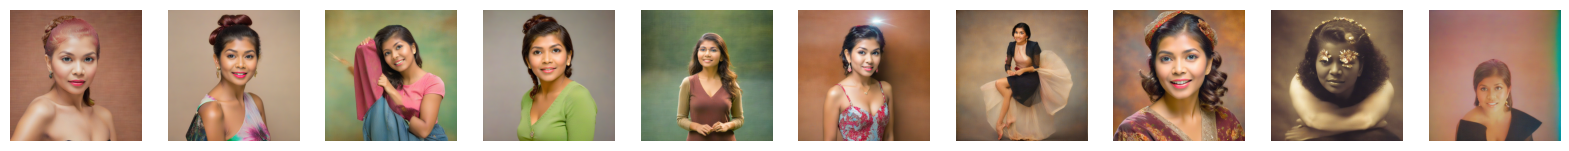

In [7]:
# prompt = "sks woman playing fetch in the park"
# negative_prompt = "low quality, blurry, unfinished"
# image = pipe(prompt, num_inference_steps=25, guidance_scale=7, negative_prompt=negative_prompt).images[0]
# 设置图片显示的大小
plt.figure(figsize=(20, 10))

for i, image in enumerate(images):
    plt.subplot(1, len(images), i+1)
    plt.imshow(image)
    plt.axis('off')  # 不显示坐标轴

plt.show()



## Test Guidance Scale with negative prompt

Generating images with guidance_scale=2:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with guidance_scale=3:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with guidance_scale=5:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with guidance_scale=7:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with guidance_scale=10:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with guidance_scale=12:   0%|          | 0/1 [00:00<?, ?it/s]

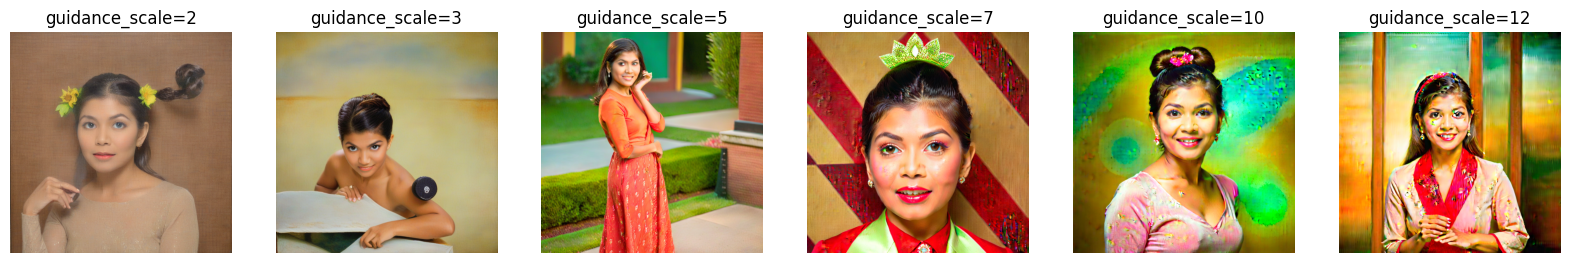

In [8]:
# 定义要测试的 guidance_scale 列表
guidance_scales = [2, 3, 5, 7, 10, 12]

# 定义用于存储图像的列表
images_dict = {scale: [] for scale in guidance_scales}

# 生成图像并存储
for scale in guidance_scales:
    for _ in tqdm(range(1), desc=f"Generating images with guidance_scale={scale}"):
        image = pipeline(prompt, num_inference_steps=25, generator=generator, guidance_scale=scale, negative_prompt=negative_prompt).images[0]
        images_dict[scale].append(image)

# 设置图片显示的大小
plt.figure(figsize=(20, 10))

# 绘制每个 guidance_scale 生成的第一张图像
for i, scale in enumerate(guidance_scales):
    plt.subplot(1, len(guidance_scales), i+1)
    plt.imshow(images_dict[scale][0])
    plt.title(f'guidance_scale={scale}')
    plt.axis('off')  # 不显示坐标轴

plt.show()


### Test guidance scale without negative prompt

Generating images with guidance_scale=2:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with guidance_scale=3:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with guidance_scale=5:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with guidance_scale=7:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with guidance_scale=10:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with guidance_scale=12:   0%|          | 0/1 [00:00<?, ?it/s]

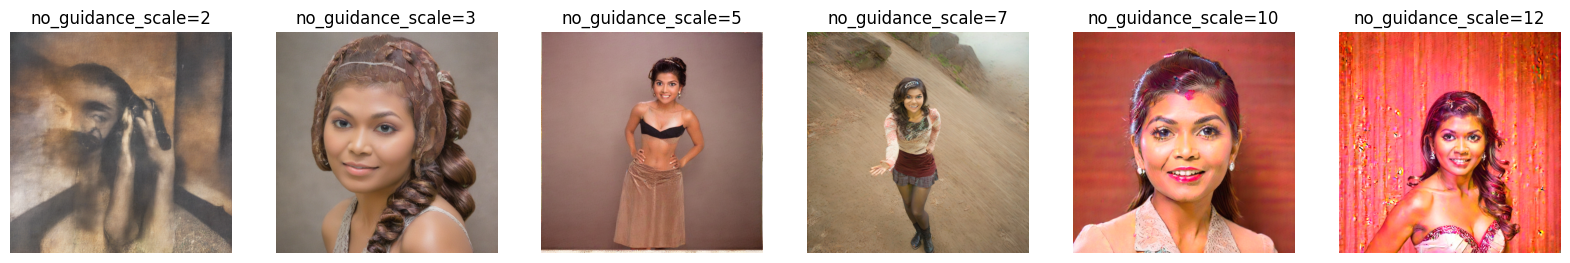

In [9]:
# 定义要测试的 guidance_scale 列表
guidance_scales = [2, 3, 5, 7, 10, 12]

# 定义用于存储图像的列表
images_dict = {scale: [] for scale in guidance_scales}

# 生成图像并存储
for scale in guidance_scales:
    for _ in tqdm(range(1), desc=f"Generating images with guidance_scale={scale}"):
        image = pipeline(prompt, num_inference_steps=50, generator=generator, guidance_scale=scale).images[0]
        images_dict[scale].append(image)

# 设置图片显示的大小
plt.figure(figsize=(20, 10))

# 绘制每个 guidance_scale 生成的第一张图像
for i, scale in enumerate(guidance_scales):
    plt.subplot(1, len(guidance_scales), i+1)
    plt.imshow(images_dict[scale][0])
    plt.title(f'no_guidance_scale={scale}')
    plt.axis('off')  # 不显示坐标轴

plt.show()


### test inference step

Generating images with inference_step=5:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with inference_step=10:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with inference_step=15:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with inference_step=20:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with inference_step=25:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with inference_step=30:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with inference_step=35:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with inference_step=40:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with inference_step=45:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with inference_step=50:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with inference_step=55:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with inference_step=60:   0%|          | 0/1 [00:00<?, ?it/s]

Generating images with inference_step=80:   0%|          | 0/1 [00:00<?, ?it/s]

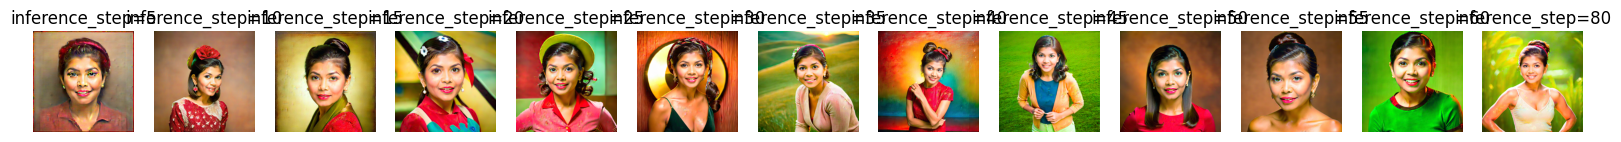

In [10]:
# 定义要测试的 guidance_scale 列表
inference_steps = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 80]

# 定义用于存储图像的列表
images_dict = {inference_step: [] for inference_step in inference_steps}

# 生成图像并存储
for inference_step in inference_steps:
    for _ in tqdm(range(1), desc=f"Generating images with inference_step={inference_step}"):
        image = pipeline(prompt, num_inference_steps=inference_step, generator=generator, guidance_scale=7, negative_prompt=negative_prompt).images[0]
        images_dict[inference_step].append(image)

# 设置图片显示的大小
plt.figure(figsize=(20, 10))

# 绘制每个 guidance_scale 生成的第一张图像
for i, inference_step in enumerate(inference_steps):
    plt.subplot(1, len(inference_steps), i+1)
    plt.imshow(images_dict[inference_step][0])
    plt.title(f'{inference_step}')
    plt.axis('off')  # 不显示坐标轴

plt.show()


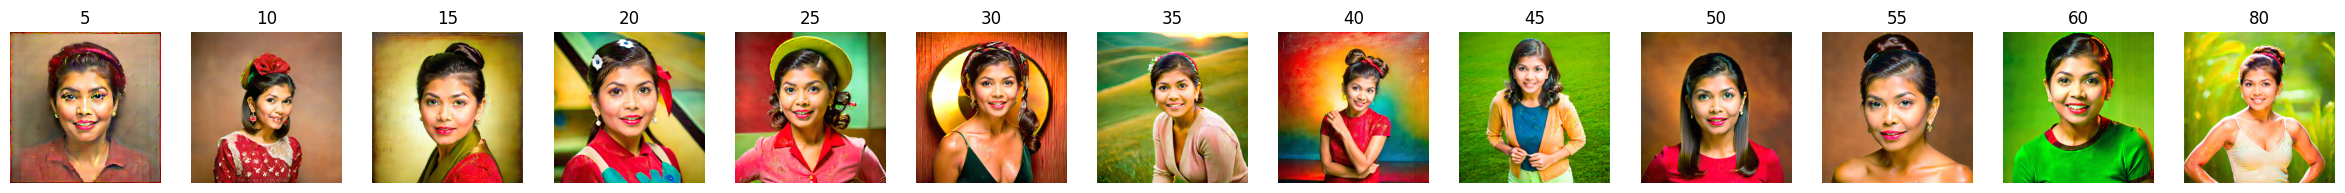

In [13]:
# from IPython.display import display

# for image in images:
#     display(image)
# 设置图片显示的大小
# plt.figure(figsize=(30, 10))

# # 绘制每个 guidance_scale 生成的第一张图像
# for i, inference_step in enumerate(inference_steps):
#     plt.subplot(1, len(inference_steps), i+1)
#     plt.imshow(images_dict[inference_step][0])
#     plt.title(f'{inference_step}')
#     plt.axis('off')  # 不显示坐标轴

# plt.show()



In [12]:
# del pipeline
# torch.cuda.empty_cache()
